**Importing Libraries**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re                   # regular expression
from wordcloud import WordCloud

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences     # for constant length input we need to do pading
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Conv1D,MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score


**Loading the dataset**

In [5]:
fake=pd.read_csv('Fake.csv')
real=pd.read_csv('True.csv')

In [6]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [9]:
fake.subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

C:\Users\abc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='subject', ylabel='count'>

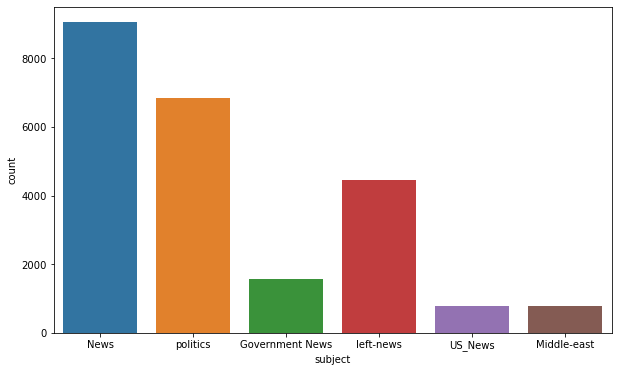

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(fake.subject)

# word cloud

In [11]:
type(fake.text)

pandas.core.series.Series

In [12]:
# now will mix all the text data together
text=' '.join(fake['text'].tolist())             # the fake.text was in series we are going to convert into list and then we are joining in to a single sentence

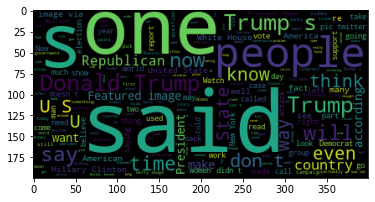

In [13]:
# printing the wordcloud of fake text data
wordcloud=WordCloud().generate(text)
plt.imshow(wordcloud)

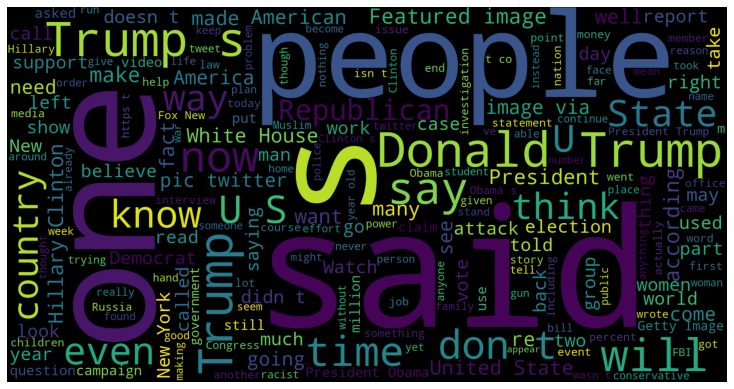

In [14]:
# will plot the same in clear format by increasing the size of the image
wordcloud=WordCloud(width=1920,height=1000).generate(text)          # we are using wordcloud to visualize more frequent word present in the sentence
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')             # to swith off the axis
plt.tight_layout(pad=0)      # to give some space 
plt.show()

Will plot the word plot for real news

In [15]:
text=' '.join(real['text'].tolist())

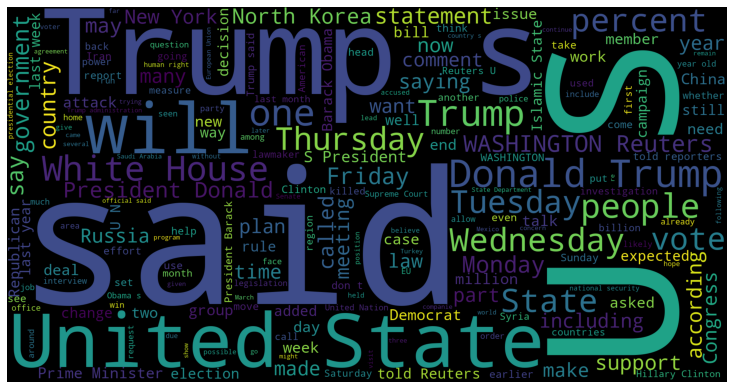

In [16]:
# will plot the same in clear format by increasing the size of the image
wordcloud=WordCloud(width=1920,height=1000).generate(text)          # we are using wordcloud to visualize more frequent word present in the sentence
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')             # to swith off the axis
plt.tight_layout(pad=0)      # to give some space 
plt.show()

you can see both fake and real wordcloud are same but in real wordcloud you can see that 'white house' and 'washington reuters' are repeated most of the time in real news 

If it is real news then their will be reference to the publications 

Difference in Text

Real news seems to have source of publication which is not present in fake news set
Looking at the Data:



*   Most of text contains reuters information such as **washington (Reuters)**
*   Some text are tweets from Twitter
*   Few text do not contain any publication info



# Cleaning Data

## Removing Reuters or Twitter Tweet Information from the text 

  *  Text can be splitted only once at "**-**" which is always present after mentioning source of publication, this gives us publication part and text part 
  *  If we do not get text part, this means publication details was'nt given for the record 
  *  The Twitter tweets always have same source, a long text of max 259 characters



In [17]:
# Now will create list of indexes which donot have publication information 

unknown_publishers=[]
for index,row in enumerate(real.text.values):
  try:
    record=row.split('-',maxsplit=1)
    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)

In [18]:
len(unknown_publishers)

221

In [19]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 221, dtype: object

In [20]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [21]:
real= real.drop(8970,axis=0)

In [22]:
publisher = []
tmp_text = []

for index,row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')

  else:
    record=row.split('-',maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [23]:
real['publisher']=publisher
real['text']=tmp_text

In [24]:
np.array(publisher).shape

(21416,)

In [25]:
[index  for index,text in enumerate(real.text.tolist()) if str(text).strip()=='']     # will check if their is any empty text present in the real data 

[]

In [26]:
empty_fake_index=[index  for index,text in enumerate(fake.text.tolist()) if str(text).strip()=='']   # will check if their is any empty text present in the fake data 

In [27]:
len(empty_fake_index)

630

In [28]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [29]:
# we are adding title and text to gether to the text column 
real['text']=real['title'] + ' '+ real['text']
fake['text']=fake['title']+' '+fake['text']

In [30]:
# Now will convert capital letter to small letter

real['text']=real['text'].apply(lambda x: str(x).lower())
fake['text']=fake['text'].apply(lambda x: str(x).lower())

Preprocessing Text

In [31]:
real['class']= 1
fake['class']=0

In [32]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [33]:
real=real[['text','class']]
fake=fake[['text','class']]

In [34]:
data=real.append(fake,ignore_index=True)

In [35]:
data.sample(5)

,text,class
43828,boiler room ep #81 – halloween fireside book o...,0
11627,moscow says it was london's decision to scale ...,1
25616,armed trump supporters ‘stand their ground’ o...,0
23323,watch: trump praises and shakes hands with br...,0
993,u.s. belatedly begins to comply with russia sa...,1


In [36]:
## Now will remove all the special character in the data for example
re.sub('[^A-Za-z0-9 ]', '', 'this ,. @ is # gre@t')      # by using regression expression substituting (which are all not in A-Za-z0-9)


'this   is  gret'

In [37]:
data['text']=data['text'].apply(lambda x:re.sub('[^A-Za-z0-9 ]', '', x))

In [38]:
data.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1


# Now we want to convert this text data to vectorization so we will be using Word2vec 

# Vectorization -- Word2Vec

## Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

## word embedding is the most popular representation of document vocabulary. It is capable of capturing context of word in a document, semantic and syntatic similarity, relation with other words, etc

In [39]:
import gensim

In [40]:
y=data['class'].values

In [41]:
# Now will convert the text in list of list
X=[i.split() for i in data['text'].tolist()]

In [42]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [43]:
len(X[0])

753

In [45]:
DIM=100
w2v_model = gensim.models.Word2Vec(sentences=X,vector_size=DIM,window=10,min_count=1)    # here we are going to make 10 seperate window(group) and if their is only 1 data at the last we must convert it in to vector

In [46]:
# Now will check the most similar word in our model  this is with the help of gensim
w2v_model.wv.most_similar('india')

[('pakistan', 0.6928598284721375),
 ('malaysia', 0.6817286610603333),
 ('thailand', 0.6418738961219788),
 ('china', 0.6410650014877319),
 ('beijings', 0.6173474788665771),
 ('australia', 0.6068567037582397),
 ('philippines', 0.6061029434204102),
 ('maritime', 0.6037669777870178),
 ('indias', 0.6016572117805481),
 ('indian', 0.6016436815261841)]

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [48]:
X=tokenizer.texts_to_sequences(X)

In [49]:
#tokenizer.word_index

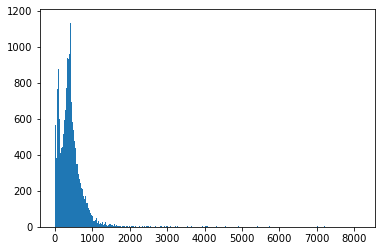

In [50]:
 plt.hist([len(i) for i in X],bins=800)
 plt.show()

Most of the list contains between 500 to 800 words

In [51]:
# now will will print the index which have more than 1000 words in the list
nos=np.array([len(i) for i in X])
len(nos[nos>1000])                    # we have 1581 sentences which have more than 1000 words

1581

### Now will make some changes which ever sentences having greater than 1000 words will be limited to 1000 words and which ever sentences is less than 1000 words will do padding and fill 0 at the initial stage and make the size =1000

In [52]:
maxlen=1000
X=pad_sequences(X,maxlen=maxlen)

In [53]:
# Now will check the size of the sentences randomly 
X[1021].size

1000

In [54]:
vocab_size = len(tokenizer.word_index) + 1
vocab=tokenizer.word_index

In [55]:
def get_weight_matrix(model):
  weight_matrix=np.zeros((vocab_size,DIM))

  for word,i in vocab.items():
    weight_matrix[i] = model.wv[word]
  
  return weight_matrix

In [56]:
embedding_vectors = get_weight_matrix(w2v_model)

In [57]:
embedding_vectors.shape

(231779, 100)

In [58]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim=DIM,weights=[embedding_vectors],input_length=maxlen,trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         23177900  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 23,295,277
Trainable params: 117,377
Non-trainable params: 23,177,900
_________________________________________________________________


In [60]:
# Now will do train test split

X_train,X_test,y_train,y_test=train_test_split(X,y)

In [61]:
model.fit(X_train,y_train,validation_split=0.3,epochs=6)


Epoch 1/6
737/737 [==============================] - 9477s 13s/step - loss: 0.1290 - acc: 0.9544 - val_loss: 0.0706 - val_acc: 0.9753
Epoch 2/6
 92/737 [==>...........................] - ETA: 57:57 - loss: 0.0516 - acc: 0.9830

KeyboardInterrupt: 

In [ ]:
y_pred=(model.predict(X_test) >=0.5).astype(int)

In [ ]:
accuracy=accuracy_score(y_test,y_pred)
accuracy

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

In [ ]:
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
def plot_roc_curve(fpr,tpr): 
    plt.figure(figsize = (20,5))
    plt.plot(fpr,tpr, color = 'green') 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    

fpr , tpr , thresholds = roc_curve (y_test , y_pred)
plot_roc_curve(fpr,tpr)

In [ ]:
# Now will give one fake news and check if the model is predicting correctly or not

new_data=['Jeevan is getting married next year and their is a huge demand']

In [ ]:
# we want to preprocess the data before sending to the model
# We want to perform tokenization and padding 

new_data=tokenizer.texts_to_sequences(new_data)
new_data=pad_sequences(new_data,maxlen=maxlen)


In [ ]:
(model.predict(new_data) >=0.5).astype(int)       # see the model is predicted as 0, 0 means its a fake news

In [ ]:
# Now will give one real news from online and check if my model is predicting correctly or not
# will copy news from :- https://www.ndtv.com/india-news/coronavirus-india-live-updates-coronavirus-cases-today-covid-19-cases-in-india-omicron-covid-cases-india-covid-19-cases-july-3-3122513
new_data=['New Delhi: India logged 16,103 new coronavirus infections taking the total tally of COVID-19 cases to 4,35,02,429, while the active cases increased to 1,11,711, according to the Union Health Ministry data updated on Sunday.']

new_data=tokenizer.texts_to_sequences(new_data)
new_data=pad_sequences(new_data,maxlen=maxlen)
(model.predict(new_data) >=0.5).astype(int)          # you can see here the model is predicting correctly its an real news


In [ ]:
# Now will write a function that takes a input news and predict if the news is fake or original

def predicting_news(a):
  new_data=tokenizer.texts_to_sequences(a)
  new_data=pad_sequences(new_data,maxlen=maxlen)
  output=(model.predict(new_data) >=0.5).astype(int)
  if output is 0:
    print('The Given News is Fake')
  else:
    print('The Given News is Original')

In [ ]:
a=["Russia Ukraine War Crisis Live Updates, July 02, 2022: As reported by Reuters, the Ambassador to Russia of the pro-Moscow self-styled Luhansk People's Republic, Rodion Miroshnik, told Russian television Lysychansk has been brought under control."]
predicting_news(a)